# Задание 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.datasets import fetch_openml

In [2]:
import os
import psutil

# Получение информации о процессоре
cpu_count = os.cpu_count()

# Определение устройства задачи для измерения показателей
task_device = 0

# Получение текущего использования процессора
usage_percent = psutil.cpu_percent(interval=1, percpu=True)[task_device]

# Расчет количества свободных ядер
free_cores_percent = 100 - usage_percent
free_cores = int(cpu_count * (free_cores_percent / 100))

In [3]:
# Загрузка датасета MNIST из библиотеки openml
mnist = fetch_openml('mnist_784', version=1)

In [4]:
X, y = mnist['data'], mnist['target'] # Разделяем данные на признаки (X) и целевую переменную (y)

In [5]:
# Разделяем данные на обучающую и тестовую выборки. В данном случае первые 60k - обучающие данные.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60_000/70_000)

In [6]:
knn_clf = KNeighborsClassifier()

In [7]:
knn_clf.fit(X_train, y_train) # Обучаем модель на обучающих данных

KNeighborsClassifier()

In [8]:
# Проводим кросс-валидацию для оценки качества модели с помощью метрики 'accuracy'
cross_val_score(knn_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.9671, 0.9668, 0.9683])

In [9]:
# Определяем параметры для поиска по сетке (Grid Search) 
parameters = {'n_neighbors': [4, 5], 'weights': ['uniform', 'distance']}

grid_search_clf = GridSearchCV(
    estimator=knn_clf,
    param_grid=parameters,
    cv=3,
    scoring='accuracy',
    n_jobs=3
) #  Поиск лучших гиперпараметров модели

grid_search_clf.fit(X_train,y_train) # Обучаем модель с использованием поиска по сетке гиперпараметров 

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=3,
             param_grid={'n_neighbors': [4, 5],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [10]:
knn_best = grid_search_clf.best_estimator_
print(f"Наилучшие параметры: {grid_search_clf.best_params_}")

Наилучшие параметры: {'n_neighbors': 4, 'weights': 'distance'}


In [11]:
cross_val_score(knn_best,X_train,y_train ,cv=3) # оценка модели

array([0.97055, 0.97195, 0.97155])

# Задание 2

In [12]:
from scipy.ndimage import shift

def shift_digits(data_frame, direction):
    """
    Сдвиг изображений с цифрами в указанном направлении.
    """
    shifted_data = data_frame.values
    for i in range(shifted_data.shape[0]):
        shifted_digit = shift(shifted_data[i].reshape(28, 28), direction)
        shifted_data[i] = shifted_digit.reshape(784,)
        
    return shifted_data

In [13]:
shifted_up = pd.DataFrame(shift_digits(X_train.copy(), [-1, 0]), columns=X_train.columns) # сдвиг вверх
shifted_down = pd.DataFrame(shift_digits(X_train.copy(), [1, 0]), columns=X_train.columns) # сдвиг вниз
shifted_right = pd.DataFrame(shift_digits(X_train.copy(), [0, 1]), columns=X_train.columns) # сдвиг вправо
shifted_left = pd.DataFrame(shift_digits(X_train.copy(), [0, -1]), columns=X_train.columns) # сдвиг влево

In [14]:
# Объединяем оригинальные и сдвинутые изображения в один DataFrame
combined_X_train = pd.concat([X_train, shifted_up, shifted_down, shifted_right, shifted_left])
combined_Y_train = pd.concat([y_train] * 5)  # Объединяем метки для всех новых данных

In [15]:
print(combined_X_train.shape)
print(combined_Y_train.shape)

(300000, 784)
(300000,)


In [16]:
cross_val_score(knn_best, combined_X_train, combined_Y_train, cv=3, scoring='accuracy') # оценка модели

array([0.98384, 0.97876, 0.9713 ])

# Задание 3

In [17]:
from sklearn.preprocessing import OrdinalEncoder

In [18]:
df = pd.read_csv('data/column_2C_weka.csv')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt numeric       310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pelvic_incidence,310.0,60.496653,17.236520,26.147921,46.430294,58.691038,72.877696,129.834041
pelvic_tilt numeric,310.0,17.542822,10.008330,-6.554948,10.667069,16.357689,22.120395,49.431864
lumbar_lordosis_angle,310.0,51.930930,18.554064,14.000000,37.000000,49.562398,63.000000,125.742385
sacral_slope,310.0,42.953831,13.423102,13.366931,33.347122,42.404912,52.695888,121.429566
pelvic_radius,310.0,117.920655,13.317377,70.082575,110.709196,118.268178,125.467674,163.071041
degree_spondylolisthesis,310.0,26.296694,37.559027,-11.058179,1.603727,11.767934,41.287352,418.543082


In [21]:
df.isnull().sum() # Проверяем наличие пропусков в данных

pelvic_incidence            0
pelvic_tilt numeric         0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64

In [22]:
df.duplicated().sum() # Проверяем количество дубликатов в данных

np.int64(0)

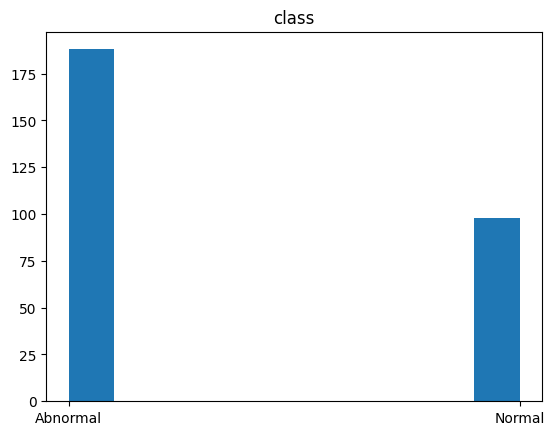

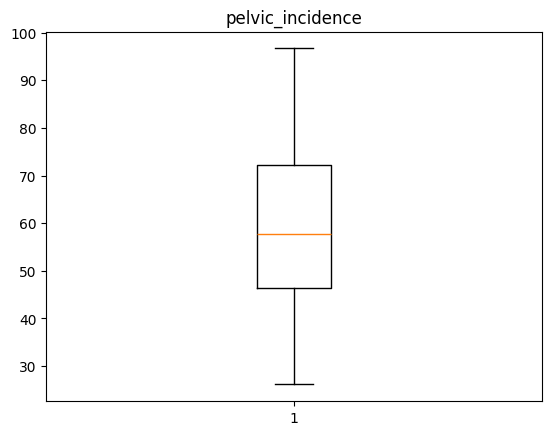

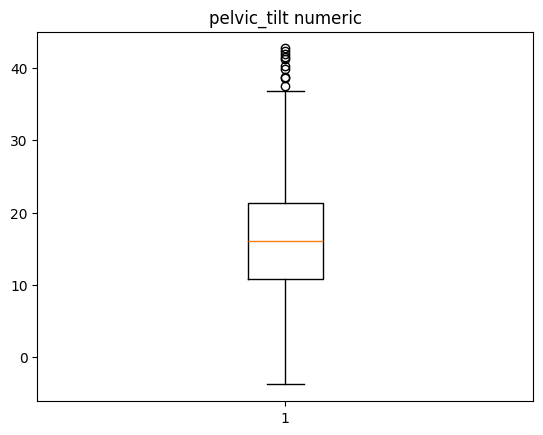

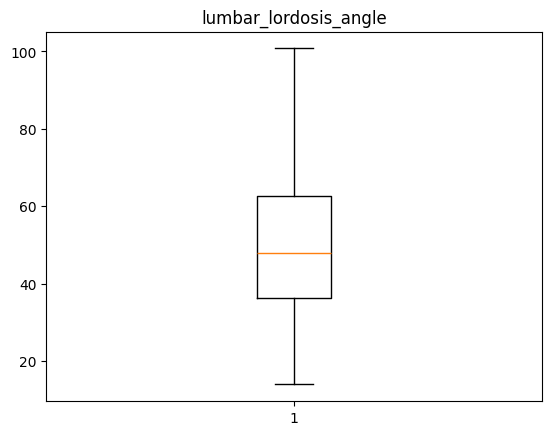

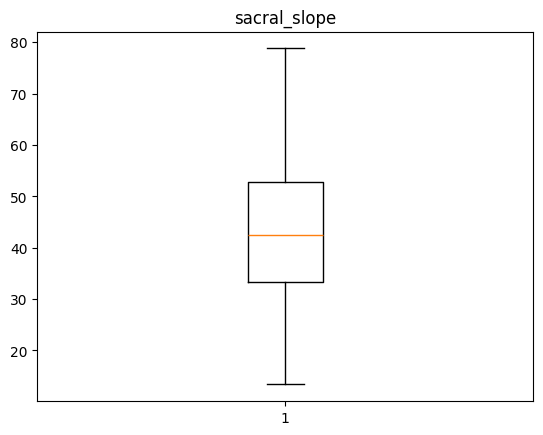

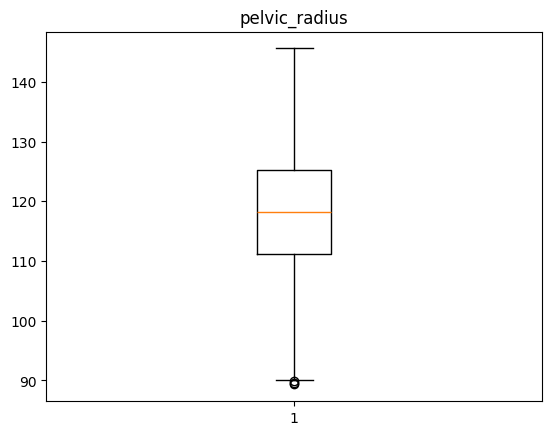

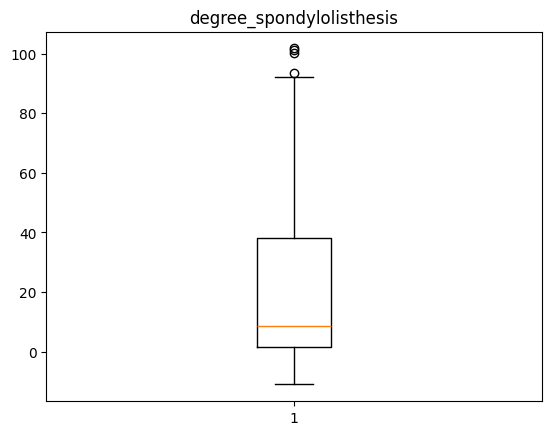

In [23]:
##==> Визуализация данных
###########################################

data_frame = df[
    (df['pelvic_incidence'] < 100) &
    (df['pelvic_tilt numeric'].between(-4, 45)) &
    (df['lumbar_lordosis_angle'] < 110) &
    (df['pelvic_radius'].between(89, 147)) &
    (df['degree_spondylolisthesis'] < 102)
]

for column in ['class', 'pelvic_incidence', 'pelvic_tilt numeric', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']:
    plt.figure()
    plt.hist(data_frame[column]) if column == 'class' else plt.boxplot(data_frame[column])
    plt.title(column)
    plt.show()

In [24]:
# Кодирование классов
data_frame['class'] = OrdinalEncoder(categories=[['Abnormal', 'Normal']]).fit_transform(data_frame[['class']])

/tmp/ipykernel_2952193/4228750957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['class'] = OrdinalEncoder(categories=[['Abnormal', 'Normal']]).fit_transform(data_frame[['class']])


In [25]:
# Подготовка данных для обучения
features = data_frame.drop('class', axis=1)
target = data_frame['class']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5)

In [26]:
# Обучение и оценка модели
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
print(f'Точность на тестовом наборе: {cross_val_score(knn_classifier, X_test, y_test, cv=3, scoring="accuracy").mean()}')

Точность на тестовом наборе: 0.8316532258064516


In [27]:
# Оптимизация гиперпараметров
param_grid = {'n_neighbors': range(1, 11), 'weights': ['uniform', 'distance']}
best_knn_model = GridSearchCV(knn_classifier, param_grid).fit(X_val, y_val).best_estimator_
print(f'Наилучшая точность на тестовом наборе: {cross_val_score(best_knn_model, X_test, y_test, cv=3, scoring="accuracy")}')

Наилучшая точность на тестовом наборе: 0.8313172043010754
